In [14]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load data into a DataFrame
csv_file_path = 'Merged-data.csv'
df = pd.read_csv(csv_file_path)

# Create a sample DataFrame with 10,000 rows
sample_df = df.sample(n=10000, random_state=42)

# Target variable 'Ethnicity'
y = sample_df['Ethnicity']

# Drop the 'Ethnicity' column to create the feature matrix 'X'
X = sample_df.drop(['Ethnicity'], axis=1)

# Encode categorical columns in the feature matrix
categorical_columns = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_columns, drop_first=True)

# Use label encoding for the 'Ethnicity' target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

# SelectKBest class with chi-squared as the score function and specify the number of features to select
k_best = SelectKBest(score_func=chi2, k=5)  # Select the top 5 features

# Fit and transform the feature matrix to select the best features
X_train_selected = k_best.fit_transform(X_train, y_train)

# Get the indices of the selected features
selected_feature_indices = k_best.get_support(indices=True)

# Create a new DataFrame with the selected features
X_test_selected = X_test.iloc[:, selected_feature_indices]

# Train a classifier on the selected features
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test_selected)

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Accuracy on the test set: {accuracy:.2f}")

# Make predictions on the training set
y_train_pred = classifier.predict(X_train_selected)

# Calculate accuracy on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print the training accuracy
print(f"Accuracy on the training set: {train_accuracy:.2f}")



Accuracy on the test set: 0.82
Accuracy on the training set: 0.99


/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [13]:
# Get the column names of the selected features
selected_feature_names = X_encoded.columns[selected_feature_indices]

# Print the names of the top 5 selected features
print("Top 5 Selected Features:")
for feature in selected_feature_names:
    print(feature)


Top 5 Selected Features:
Contacts
FaceToFaceContacts
BednightsRate
ContactsRate
FaceToFaceContactsRate


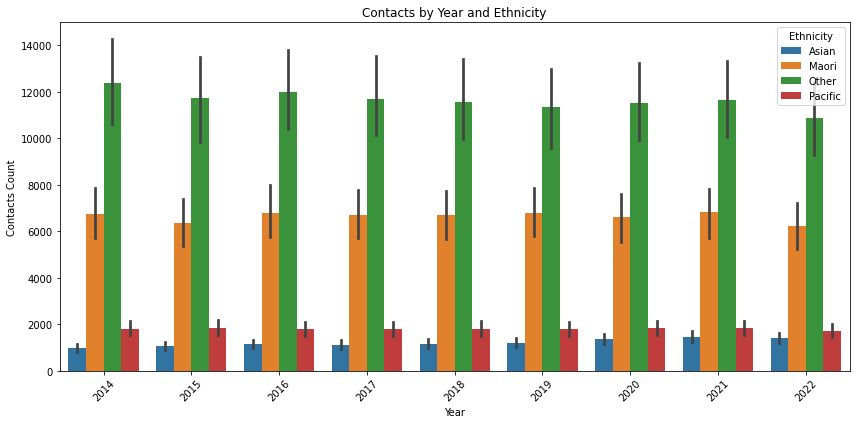

In [16]:
#Plots#

import matplotlib.pyplot as plt
import seaborn as sns
df_filtered = df[df['Ethnicity'] != 'Total']

pdf_filtered = df[df['Ethnicity'] != 'Total']

# Create a bar plot to show the count of 'ClientsSeen' per 'Year' and 'Ethnicity'
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='Contacts', hue='Ethnicity', data=df_filtered)
plt.title('Contacts by Year and Ethnicity')
plt.xlabel('Year')
plt.ylabel('Contacts Count')
plt.xticks(rotation=45)
plt.legend(title='Ethnicity')

plt.tight_layout()
plt.show()

Before Log Transformation:
+-------+---------+------------------+---------+------+--------+-------+------+------------+------------+------------------+---------------------+-----------------+-----------------+------------------+-------+-----------------+-------------------------+-----------------+------------------+----------------------+--------+
|summary|Record_ID|              Year|Ethnicity|Gender|AgeGroup|OrgType|  Team|ActivityCode|ActivityType|       ClientsSeen|ClientsSeenFaceToFace|        Bednights|         Contacts|FaceToFaceContacts|AgeBins|  ClientsSeenRate|ClientsSeenFaceToFaceRate|    BednightsRate|      ContactsRate|FaceToFaceContactsRate|TeamType|
+-------+---------+------------------+---------+------+--------+-------+------+------------+------------+------------------+---------------------+-----------------+-----------------+------------------+-------+-----------------+-------------------------+-----------------+------------------+----------------------+--------+
|  c


After Log Transformation:
+-------+---------+------------------+---------+------+--------+-------+------+------------+------------+------------------+---------------------+-----------------+-----------------+------------------+-------+-----------------+-------------------------+-----------------+------------------+----------------------+--------+-------------------+-----------------------------+------------------+------------------+--------------------------+
|summary|Record_ID|              Year|Ethnicity|Gender|AgeGroup|OrgType|  Team|ActivityCode|ActivityType|       ClientsSeen|ClientsSeenFaceToFace|        Bednights|         Contacts|FaceToFaceContacts|AgeBins|  ClientsSeenRate|ClientsSeenFaceToFaceRate|    BednightsRate|      ContactsRate|FaceToFaceContactsRate|TeamType|ClientsSeenRate_log|ClientsSeenFaceToFaceRate_log| BednightsRate_log|  ContactsRate_log|FaceToFaceContactsRate_log|
+-------+---------+------------------+---------+------+--------+-------+------+------------+-----

23/10/04 20:18:10 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


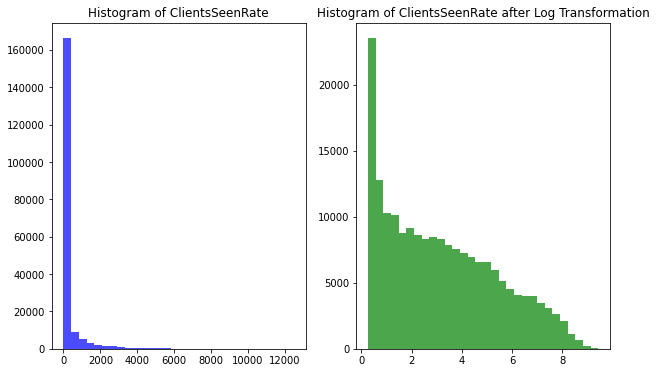

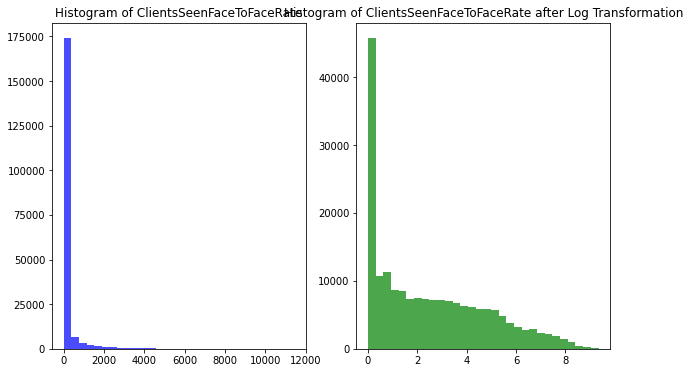

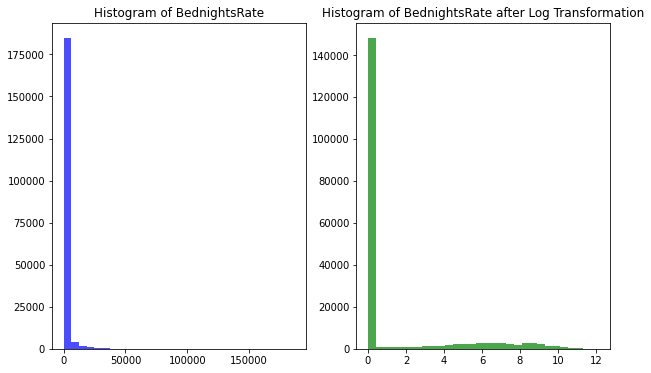

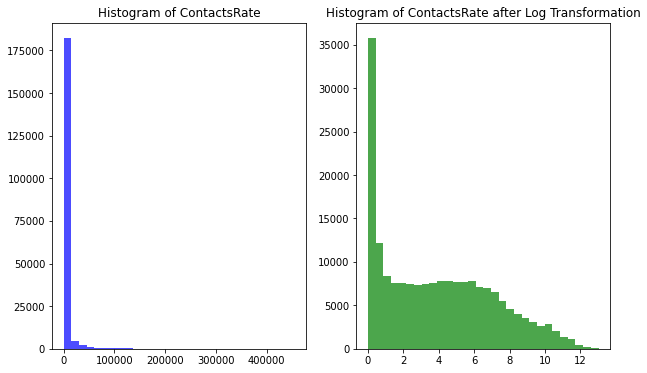

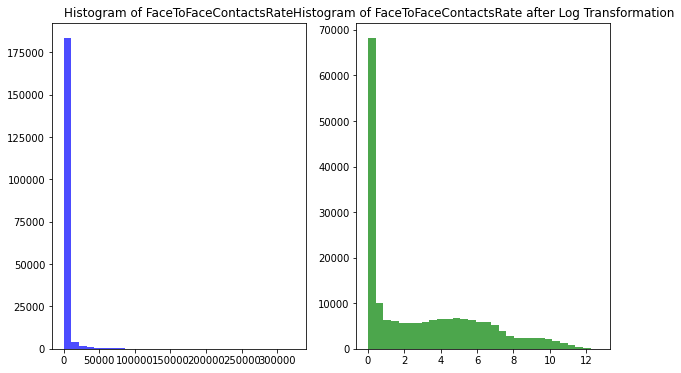

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import log
import matplotlib.pyplot as plt
# Create a Spark session
spark = SparkSession.builder.appName("LogTransformationExample").getOrCreate()
# Load data into a PySpark DataFrame
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
# Use the describe() function to display statistical measures
statistics = df.describe()
# Display the results
print("Before Log Transformation:")
statistics.show()
# Select the numeric columns for log transformation
numeric_columns = [col_name for col_name, data_type in df.dtypes if data_type == 'double']
# Apply log transformation to numeric columns
for col in numeric_columns:
    df = df.withColumn(col + '_log', log(df[col] + 1))  # Adding 1 to avoid log(0)
# Display statistical measures after log transformation
transformed_statistics = df.describe()
# Display the results after log transformation
print("\nAfter Log Transformation:")
transformed_statistics.show()
# Visualize the log-transformed data
for col in numeric_columns:
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.hist(df.select(col).rdd.flatMap(lambda x: x).collect(), bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram of {col}')
    
    plt.subplot(1, 2, 2)
    plt.hist(df.select(col + '_log').rdd.flatMap(lambda x: x).collect(), bins=30, color='green', alpha=0.7)
    plt.title(f'Histogram of {col} after Log Transformation')
    
    plt.show()

# Stop the Spark session
spark.stop()


In [19]:
from pyspark.sql import SparkSession
import pandas as pd

# Create a Spark session
spark = SparkSession.builder.appName("DescribeExample").getOrCreate()

# Assuming 'df' is your PySpark DataFrame
# Replace 'Merged-data.csv' with your actual CSV file path
csv_file_path = 'Merged-data.csv'
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Use the describe() function to get statistical measures
statistics = df.describe()

# Convert PySpark DataFrame to Pandas DataFrame for better formatting
statistics_pandas = statistics.toPandas()

# Display the results in a better format
print("Statistical Measures:")
print(statistics_pandas)

# Stop the Spark session
spark.stop()



Statistical Measures:
  summary Record_ID                Year Ethnicity  Gender AgeGroup OrgType  \
0   count    192220              192220    192220  192220   192220  192220   
1    mean      None  2018.0523046509209      None    None     None    None   
2  stddev      None   2.567499664373153      None    None     None    None   
3     min     MH100                2014     Asian  Female    00-04     DHB   
4     max    MH9999                2022     Total   Total      85+   Total   

     Team ActivityCode ActivityType  ...          Bednights  \
0  192220       192220       192220  ...             192220   
1    None         None         None  ...  1104.044423056914   
2    None         None         None  ...  5471.018758807469   
3     A&D           AV          T01  ...                  0   
4   Total           YJ        Total  ...             124894   

            Contacts  FaceToFaceContacts AgeBins    ClientsSeenRate  \
0             192220              192220  192220           